In [124]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

In [125]:
tf.reset_default_graph()

In [126]:
num_samples = 100000

In [150]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))
print(version)

[ 0.03350895  0.00112587  0.58922285 ...,  0.76625353  0.36059403
  0.20961428]
[ 0.30066064  0.2874691   0.38069139 ...,  0.38893525  0.33226251
  0.32306408]


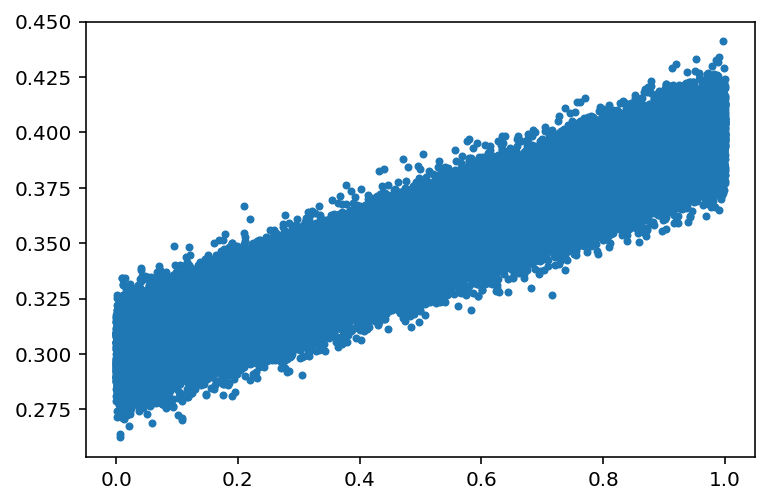

In [127]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

### Create Model Test/Validation Data 

[ 0.82009536  0.04119873  0.68093044 ...,  0.30944175  0.6825068
  0.58442163]
[ 0.37524581  0.30357996  0.37076404 ...,  0.33201261  0.37460026
  0.35673534]


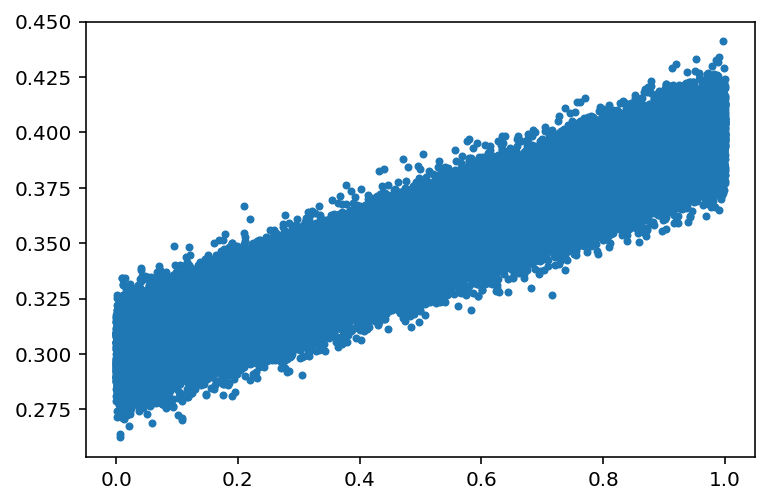

In [128]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_train, y_train, '.')

In [129]:
# 1.3 Build inference graph.
# Create Variables W and b that compute y = W * x + b
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

  # Create a placeholder we'll use later to feed x's into the graph for training and test.
  # shape=[None] means we can put in any number of examples. 
  # This is used for minibatch training, and to evaluate a lot of examples at once.
  x_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='x_observed')
  print(x_observed)

with tf.device("/cpu:0"):
#  with jit_scope():
    # Same as tf.add(tf.matmul(W, tf.transpose(x)), b)
    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:CPU:0)


In [130]:
# 1.4 Build training graph.
# Create an operation that calculates loss.

# Create a placeholder we'll use later to feed the correct y value into the graph
with tf.device("/cpu:0"):
#  with jit_scope():
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))

    # Create an optimizer.
    optimizer_op = tf.train.GradientDescentOptimizer(0.025)  

    # Create an operation that minimizes loss.
    train_op = optimizer_op.minimize(loss_op)  

    # 'loss', 'optimizer' and 'train' are.
    print("loss:", loss_op)
    print("optimizer:", optimizer_op)
    print("train:", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
loss: Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
optimizer: <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f2c312aaeb8>
train: name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



In [131]:
# Create an operation to initialize all the variables.
with tf.device("/cpu:0"):
  init_op = tf.global_variables_initializer()
  print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [133]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/train' % version, graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/test' % version, graph=tf.get_default_graph())

1490930570


In [134]:
config = tf.ConfigProto(
  log_device_placement=True,
)
print(config)

sess = tf.Session(config=config)

3.69549e-06
-0.520769


In [ ]:
sess.run(init_op)
print(sess.run(W))
print(sess.run(b))

## Accuracy of Random Weights

In [135]:
# Convenience method for evaluating the loss (error)
def test(x, y):
  return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [136]:
# Calculate accuracy on the test data using random initial values for y
# Note:  This should be relatively far from 0 since we haven't yet trained the model
test(x=x_test, y=y_test)

0.75923634

In [137]:
# Add a Summary Operation so we can visualize the loss in TensorBoard
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

# Train Model

In [138]:
%%time

max_steps = 300

run_metadata = tf.RunMetadata()

for step in range(max_steps):
  # Run the training op; feed the training data into the graph
  if (step < max_steps):
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
  else:  
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
    with open('cpu-timeline.json', 'w') as trace_file:
      trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

# The following take a relatively long time, so do them at periodic intervals
  if step % 5 == 0:
    print(step, sess.run([W, b]))
    train_summary_writer.add_summary(train_summary_log, step)
    train_summary_writer.flush()
    test_summary_writer.add_summary(test_summary_log, step)
    test_summary_writer.flush()

0 [0.022155864, -0.47723439]
5 [0.11284913, -0.29721022]
10 [0.17710589, -0.16681802]
15 [0.22232166, -0.072217919]
20 [0.25382799, -0.0034319279]
25 [0.27546832, 0.04673367]
30 [0.29001331, 0.083465457]
35 [0.29946023, 0.11050287]
40 [0.30524868, 0.13054197]
45 [0.30841631, 0.14552668]
50 [0.30971086, 0.15685861]
55 [0.30967125, 0.1655484]
60 [0.30868575, 0.17232482]
65 [0.30703396, 0.17771339]
70 [0.30491716, 0.18209316]
75 [0.30248031, 0.18573754]
80 [0.29982764, 0.18884374]
85 [0.29703403, 0.19155414]
90 [0.29415327, 0.19397144]
95 [0.29122388, 0.19616984]
100 [0.28827336, 0.19820298]
105 [0.28532135, 0.20010962]
110 [0.28238177, 0.20191786]
115 [0.27946442, 0.20364803]
120 [0.27657619, 0.20531495]
125 [0.27372181, 0.20692939]
130 [0.27090451, 0.20849924]
135 [0.26812634, 0.21003027]
140 [0.26538864, 0.2115268]
145 [0.26269212, 0.21299203]
150 [0.26003715, 0.21442835]
155 [0.25742376, 0.21583761]
160 [0.25485185, 0.21722125]
165 [0.25232103, 0.21858037]
170 [0.24983099, 0.2199159]


(0, 1.0)

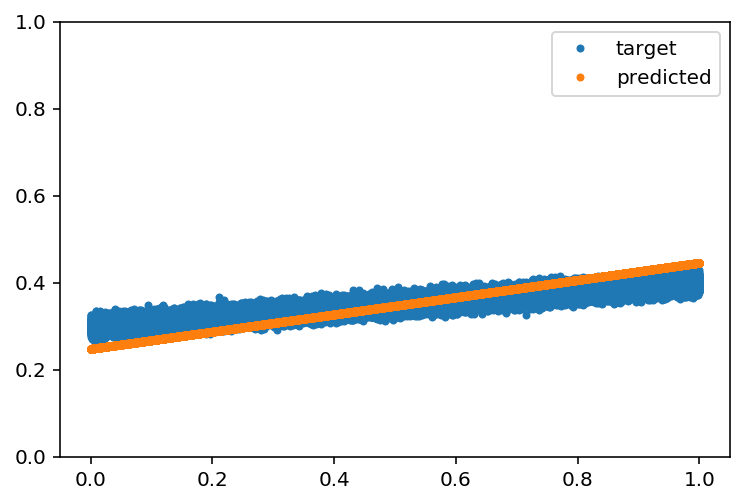

In [139]:
# Plot the predicted values
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, feed_dict={x_observed: x_train, y_observed: y_train}), ".", label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

In [140]:
# Check accuracy on eval data after training
# Note:  This should be close to 0!
test(x=x_test, y=y_test)

0.00090969104

In [142]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

name: "x_observed:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "add:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}



In [143]:
export_path = "/root/models/linear/cpu/%s" % version
print(export_path)

/root/models/linear/cpu/1490930570


In [144]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

with tf.device("/cpu:0"):
  builder = saved_model_builder.SavedModelBuilder(export_path)

prediction_signature =  signature_def_utils.build_signature_def(
    inputs = {'x_observed': tensor_info_x_observed}, 
    outputs = {'y_pred': tensor_info_y_pred}, 
    method_name = signature_constants.PREDICT_METHOD_NAME)            

legacy_init_op = tf.group(tf.initialize_all_tables(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, 
  [tag_constants.SERVING],
  signature_def_map={'predict':prediction_signature,
  signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
  legacy_init_op=legacy_init_op)

builder.save()

Instructions for updating:
Use `tf.tables_initializer` instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/root/models/linear/cpu/1490930570/saved_model.pb'


b'/root/models/linear/cpu/1490930570/saved_model.pb'

### Copy/Paste the version number and insert it below 

In [149]:
%%bash

ls -l /root/models/linear/cpu/1490930570

total 24
-rw-r--r-- 1 root root 19796 Mar 31 03:22 saved_model.pb
drwxr-xr-x 2 root root  4096 Mar 31 03:22 variables


## Save the Model in Previous Tensorflow Model Format
We will use this later.

In [146]:
from tensorflow.python.framework import graph_io
graph_io.write_graph(sess.graph, "/root/models/optimize_me/", "unoptimized_cpu.pb")

'/root/models/optimize_me/unoptimized_cpu.pb'

In [147]:
sess.close()

## Look at the Model In Tensorboard

http://[ip-address]:6006